In [3]:
import time
import sys
import os 
import json
import pickle
import torch
from torch_geometric.data import Data, DataLoader

common_path = os.path.abspath(os.path.join("__file__", "../../src/common"))
eval_path = os.path.abspath(os.path.join("__file__", "../../src/evaluation"))
src_path = os.path.abspath(os.path.join("__file__", "../../src"))
sys.path.append(common_path)
sys.path.append(src_path)
sys.path.append(eval_path)
sys.argv = ["bar"]

from scene2graph import Graph, GraphNode
from query import query
from utils import get_config
from cont_train import cont_single
from embedding import GNN, SceneDataset, create_dataset

log path :/Users/jianihuang/Desktop/research/synthesis_specs/data/log/5e-05-penyes-preno_intermediate-norno-None.log
Namespace(batch_size=5, beam_size=30, dataset_name='img_test_500.pt', decay=0.95, embedding_dim=64, episode_iter=50000, episode_length=10, eps=0.2, eps_decay=0.99, graph_file_name='img_test_500.pkl', hard_constraint=True, hidden_dim=64, json_path='/Users/jianihuang/Desktop/research/synthesis_specs/data/temp/query-5e-05-penyes-preno_intermediate-norno-None.json', log_name=None, log_path='/Users/jianihuang/Desktop/research/synthesis_specs/data/log/5e-05-penyes-preno_intermediate-norno-None.log', lr=5e-05, max_obj_num=20, max_sub_prob=20, max_var_num=3, model_dir='/Users/jianihuang/Desktop/research/synthesis_specs/data/model', model_path='/Users/jianihuang/Desktop/research/synthesis_specs/data/model/refrl-5e-05-penyes-no_intermediate-norno-None.pkl', normalize_reward=False, reward_penalty=True, reward_type='no_intermediate', save_num=500, scene_file_name='img_test_500.json'

In [4]:
# directories
data_dir = os.path.abspath(os.path.join(os.path.abspath("__file__"), "../../data"))
model_dir = os.path.abspath(os.path.join(data_dir, "oak_model/model"))

# graph information
graph_file_name = "img_test_500.pkl"
graph_path = os.path.join(data_dir, f"./processed_dataset/raw/{graph_file_name}")

# scene information
scene_file_name = "img_test_500.json"
raw_path = os.path.abspath(os.path.join(data_dir, "./processed_dataset/raw"))
scenes_path = os.path.abspath(os.path.join(raw_path, scene_file_name))

# image information
image_file_name = "bob-view.png"
image_path = os.path.abspath(os.path.join("__file__", f"../{image_file_name}"))

# model information
model_path = os.path.join(model_dir, "refrl-0.0001-penyes-no_intermediate-norno-img_test_30.pkl")

In [5]:
# load graph and scene info
graphs, scene_dataset = create_dataset(data_dir, scenes_path, graph_path)
refrl = torch.load(model_path)
dataloader = DataLoader(scene_dataset)

['large', 'small', 'blue', 'red', 'yellow', 'green', 'gray', 'brown', 'purple', 'cyan', 'cube', 'cylinder', 'sphere', 'rubber', 'metal', 'right', 'behind', 'target', 'obj_0', 'obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11', 'obj_12', 'obj_13', 'obj_14', 'obj_15', 'obj_16', 'obj_17', 'obj_18', 'obj_19', 'var_0', 'var_1', 'var_2', 'size', 'color', 'shape', 'material', 'bonding', 'edge_attr', 'first', 'second', 'target', 'center_relation']


/Users/jianihuang/anaconda3/envs/torch_graphic/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'rl.NodeSelPolicy' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/jianihuang/anaconda3/envs/torch_graphic/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'decoder.NodeDecoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
obj2idx = {}

obj2idx["A"] = 17
obj2idx["E"] = 18
obj2idx["C"] = 19
obj2idx["B"] = 20
obj2idx["I"] = 21
obj2idx["G"] = 22
obj2idx["F"] = 23
obj2idx["D"] = 24
obj2idx["H"] = 25
obj2idx["J"] = 26

scene = graphs[22].scene
config = get_config()

In [7]:
def get_trained_prog(target_label):
    prob_id = obj2idx[target_label]
    
    file_name = None
    save_dir = None
    

    data_point = next(x for i,x in enumerate(dataloader) if i == prob_id)
    policy = refrl.policy
    attr_encoder = refrl.dataset.attr_encoder
    
    policy, success_progs = cont_single(file_name, data_point, policy, graphs, save_dir, attr_encoder, config, save=False)
    return policy, success_progs

def get_further_trained_prog(policy, target_label):
    prob_id = obj2idx[target_label]
    
    file_name = None
    save_dir = None
    

    data_point = next(x for i,x in enumerate(dataloader) if i == prob_id)
    attr_encoder = refrl.dataset.attr_encoder
    
    success_progs = cont_single(file_name, data_point, policy, graphs, save_dir, attr_encoder, config, save=False)
    return policy, success_progs

In [8]:
def query2pts(scene, query_res):
    point_xs = []
    point_ys = []
    
    if not "var_0" in query_res:
        return []
    for obj_idx in query_res["var_0"]:
        point_xs.append(scene["objects"][int(obj_idx)]["pixel_coords"][0])
        point_ys.append(scene["objects"][int(obj_idx)]["pixel_coords"][1])
    return point_xs, point_ys

##### Meta-Learnt A

In [12]:
start_time = time.time()

# seek for the clauses
a_policy, success_progs = get_trained_prog("A")
a_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(a_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['shape', 'sphere', 0], ['color', 'gray', 2], ['color', 'red', 0]]
We spent 31.869831800460815s to find out the clauses


##### Meta-Learnt B

In [11]:
start_time = time.time()

# seek for the clauses
b_policy, success_progs = get_trained_prog("B")
b_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(b_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['color', 'green', 0]]
We spent 0.13238120079040527s to find out the clauses


##### Meta-Learnt C

In [14]:
start_time = time.time()

# seek for the clauses
c_policy, success_progs = get_trained_prog("C")
c_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(c_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['size', 'large', 0], ['color', 'gray', 0]]
We spent 86.16160297393799s to find out the clauses


##### Meta-Learnt D

In [15]:
start_time = time.time()

# seek for the clauses
d_policy, success_progs = get_trained_prog("D")
d_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(d_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['shape', 'cylinder', 0]]
We spent 3.0264980792999268s to find out the clauses


##### Meta-Learnt E

In [16]:
start_time = time.time()

# seek for the clauses
e_policy, success_progs = get_trained_prog("E")
e_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(e_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['size', 'small', 2], ['color', 'purple', 0], ['material', 'rubber', 0]]
We spent 4.304054021835327s to find out the clauses


##### Meta-Learnt F

In [17]:
start_time = time.time()

# seek for the clauses
f_policy, success_progs = get_trained_prog("F")
f_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(f_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['color', 'brown', 0]]
We spent 0.13286924362182617s to find out the clauses


##### Meta-Learnt G

In [12]:
start_time = time.time()

# seek for the clauses
g_policy, success_progs = get_trained_prog("G")
g_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(g_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['behind', 1, 2], ['behind', 0, 1], ['color', 'gray', 0], ['shape', 'sphere', 2]]
We spent 22.444822072982788s to find out the clauses


##### Meta-Learnt H

In [8]:
start_time = time.time()

# seek for the clauses
h_policy, success_progs = get_trained_prog("H")
h_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(h_clauses)
print(f"We spent {time_spent}s to find out the clauses")

[['right', 2, 0], ['shape', 'cube', 2], ['right', 2, 1], ['shape', 'cube', 1], ['behind', 2, 0], ['shape', 'cube', 0]]
We spent 529.9074540138245s to find out the clauses


##### Meta-Learnt I

In [20]:
start_time = time.time()

# seek for the clauses
i_policy, success_progs = get_trained_prog("I")
i_clauses = success_progs[0]

end_time = time.time()
time_spent = end_time - start_time
print(i_clauses)
print(f"We spent {time_spent/10}s to find out the clauses")

[['color', 'yellow', 0]]
We spent 0.014247560501098632s to find out the clauses


In [ ]:
# clause that we have
clauses = [["behind", 0, 1], ["shape", "cube", 0], ["color", "brown", 1]]

In [26]:
# query to check the correctness
query_res = query(scene, g_clauses, config)
point_xs, point_ys = query2pts(scene, query_res)

draw the objects that satisfy the constraints

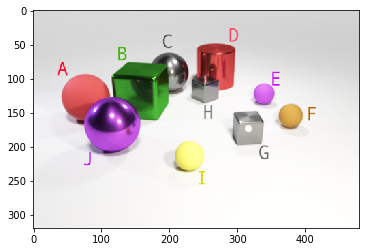

In [27]:
import matplotlib.pyplot as plt
im = plt.imread(image_path)
implot = plt.imshow(im)

plt.scatter(point_xs, point_ys, c="white")
plt.show()

generate the clauses using NN

In [64]:
scene

{'image_index': 502,
 'objects': [{'color': 'red',
   'size': 'large',
   'rotation': 48.81250167082779,
   'shape': 'sphere',
   '3d_coords': [-2.218951940536499, -2.431873321533203, 0.699999988079071],
   'material': 'rubber',
   'pixel_coords': [78, 128, 10.688728332519531]},
  {'color': 'purple',
   'size': 'small',
   'rotation': 54.76934645625753,
   'shape': 'sphere',
   '3d_coords': [0.6174756288528442, 2.4694671630859375, 0.3499999940395355],
   'material': 'rubber',
   'pixel_coords': [340, 123, 11.878174781799316]},
  {'color': 'gray',
   'size': 'large',
   'rotation': 205.00560095524148,
   'shape': 'sphere',
   '3d_coords': [-2.3796944618225098, 0.8298053741455078, 0.699999988079071],
   'material': 'metal',
   'pixel_coords': [200, 92, 12.744452476501465]},
  {'color': 'green',
   'size': 'large',
   'rotation': 217.42306110337947,
   'shape': 'cube',
   '3d_coords': [-1.6057746410369873, -0.8591099977493286, 0.699999988079071],
   'material': 'metal',
   'pixel_coords':

In [67]:
graphs[27].target_id

0